# Structure

1. Import Dependencies
2. Import helper functions
3. Data Loading
4. Data Preprocessing
5. Encoding the target
6. Splitting the Data
7. Creating Text Vectorizer
8. Create Text Embedding
9. Create Datasets
10. Create Model
11. Compile Model
12. Fit the Model
13. Evaluate

# Importing Dependencies

In [4]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import re
import string
from string import digits
from tensorflow.keras import layers

# Importing Helper Functions

In [79]:
# Download helper functions script
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-02-21 03:04:53--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-02-21 03:04:53 (72.2 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [80]:
# Import calculate_results helper function
from helper_functions import calculate_results,create_tensorboard_callback

# Data Loading

In [5]:
df = pd.read_csv('/content/drive/MyDrive/Tensorflow_Certificate/consumer_complaints.csv')

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (5,11) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [6]:
df.head()

,date_received,product,sub_product,issue,sub_issue,consumer_complaint_narrative,company_public_response,company,state,zipcode,tags,consumer_consent_provided,submitted_via,date_sent_to_company,company_response_to_consumer,timely_response,consumer_disputed?,complaint_id
0,08/30/2013,Mortgage,Other mortgage,"Loan modification,collection,foreclosure",NaN,NaN,NaN,U.S. Bancorp,CA,95993,NaN,NaN,Referral,09/03/2013,Closed with explanation,Yes,Yes,511074
1,08/30/2013,Mortgage,Other mortgage,"Loan servicing, payments, escrow account",NaN,NaN,NaN,Wells Fargo & Company,CA,91104,NaN,NaN,Referral,09/03/2013,Closed with explanation,Yes,Yes,511080
2,08/30/2013,Credit reporting,NaN,Incorrect information on credit report,Account status,NaN,NaN,Wells Fargo & Company,NY,11764,NaN,NaN,Postal mail,09/18/2013,Closed with explanation,Yes,No,510473
3,08/30/2013,Student loan,Non-federal student loan,Repaying your loan,Repaying your loan,NaN,NaN,"Navient Solutions, Inc.",MD,21402,NaN,NaN,Email,08/30/2013,Closed with explanation,Yes,Yes,510326
4,08/30/2013,Debt collection,Credit card,False statements or representation,Attempted to collect wrong amount,NaN,NaN,Resurgent Capital Services L.P.,GA,30106,NaN,NaN,Web,08/30/2013,Closed with explanation,Yes,Yes,511067


In [7]:
df.shape

(555957, 18)

In [8]:
df.isnull().mean()*100

date_received                    0.000000
product                          0.000000
sub_product                     28.477382
issue                            0.000000
sub_issue                       61.755675
consumer_complaint_narrative    87.983603
company_public_response         84.688744
company                          0.000000
state                            0.879025
zipcode                          0.810314
tags                            85.977513
consumer_consent_provided       77.793606
submitted_via                    0.000000
date_sent_to_company             0.000000
company_response_to_consumer     0.000000
timely_response                  0.000000
consumer_disputed?               0.000000
complaint_id                     0.000000
dtype: float64

In [9]:
# Selecting X and y to proceed
df = df[['product','issue']]

In [10]:
df.head()

,product,issue
0,Mortgage,"Loan modification,collection,foreclosure"
1,Mortgage,"Loan servicing, payments, escrow account"
2,Credit reporting,Incorrect information on credit report
3,Student loan,Repaying your loan
4,Debt collection,False statements or representation


# Data Preprocessing

In [11]:
# To lower case
df['product'] = df['product'].map(lambda x: x.lower())
df['issue'] = df['issue'].map(lambda x: x.lower())

In [12]:
# Remove all Special characters
exclude = set(string.punctuation)
df['product'] = df['product'].map(lambda x: ''.join(ch for ch in x if ch not in exclude))
df['issue'] = df['issue'].map(lambda x: ''.join(ch for ch in x if ch not in exclude))

In [13]:
# Remove all numbers from text 
remove_digits = str.maketrans('','',digits)
df['product'] = df['product'].map(lambda x: x.translate(remove_digits))
df['issue'] = df['issue'].map(lambda x: x.translate(remove_digits))

# Splitting the Data

In [82]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(df['issue'],df['product'],test_size=0.2,random_state=42)

len(X_train)

444765

# Encode Target Variable

In [85]:
# One hot encode labels
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False)
y_train_encoded = one_hot_encoder.fit_transform(y_train.to_numpy().reshape(-1, 1))
y_test_encoded = one_hot_encoder.fit_transform(y_test.to_numpy().reshape(-1, 1))

# Check what training labels look like
y_train_encoded

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [14]:
# Find how many unique values
df['product'].nunique()

11

In [15]:
df['product'].value_counts()

mortgage                   186475
debt collection            101052
credit reporting            91854
credit card                 66468
bank account or service     62563
consumer loan               20990
student loan                15839
payday loan                  3877
money transfers              3812
prepaid card                 2470
other financial service       557
Name: product, dtype: int64

In [86]:
# Using Label Encoding
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

y_test_label_encoded = le.fit_transform(y_test)

In [88]:
# Class names
class_names = le.classes_
class_names

array(['bank account or service', 'consumer loan', 'credit card',
       'credit reporting', 'debt collection', 'money transfers',
       'mortgage', 'other financial service', 'payday loan',
       'prepaid card', 'student loan'], dtype=object)

# Find metrics of Feature

## Find Average Sentence Length

In [42]:
# How long is each sentence on average?
sent_lens = [len(sentence.split()) for sentence in df['issue']]
avg_sent_len = np.mean(sent_lens)
avg_sent_len # return average sentence length (in tokens)

4.004075854787331

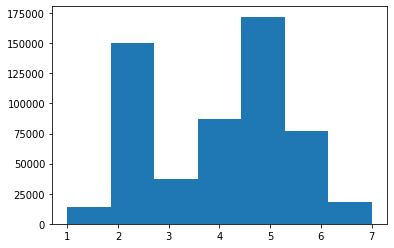

In [43]:
# What's the distribution look like?
import matplotlib.pyplot as plt
plt.hist(sent_lens, bins=7);

In [44]:
# How long of a sentence covers 95% of the lengths?
output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len

6

In [45]:
# Maximum sentence length in the training set
max(sent_lens)

7

## Find Vocab Length

In [46]:
vocab = set()

for sent in df['issue']:
  for word in sent.split():
    if word not in vocab:
      vocab.add(word)

In [47]:
len(vocab)

192

# Text Vectorizer

In [48]:
# How many words are in our vocabulary
max_tokens = 192

In [49]:
# Create text vectorizer
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

text_vectorizer = TextVectorization(max_tokens = max_tokens,
                                    output_sequence_length=output_seq_len)

In [50]:
# Adapt text vectorizer to training sentences
text_vectorizer.adapt(X_train)

In [51]:
X_train[1]

'loan servicing payments escrow account'

# Custom Embedding

In [52]:
# Create token embedding layer
token_embed = layers.Embedding(input_dim=len(vocab), # length of vocabulary
                               output_dim=128, # Note: different embedding sizes result in drastically different numbers of parameters to train
                               # Use masking to handle variable sequence lengths (save space)
                               mask_zero=True,
                               name="token_embedding") 

# Create Datasets

In [89]:
# Turn our data into TensorFlow Datasets
import tensorflow as tf 

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train_encoded))
valid_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test_encoded))
# test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

train_dataset

<TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(11,), dtype=tf.float64, name=None))>

In [90]:
# Take the TensorSliceDataset's and turn them into prefetched batches
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Model 1: Conv1D

## Model Building and Training

In [91]:
# Create 1D convolutional model to process sequences
inputs = layers.Input(shape=(1,), dtype=tf.string)
text_vectors = text_vectorizer(inputs) # vectorize text inputs
token_embeddings = token_embed(text_vectors) # create embedding
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(token_embeddings)
x = layers.GlobalAveragePooling1D()(x) # condense the output of our feature vector
outputs = layers.Dense(11, activation="softmax")(x)
model_1 = tf.keras.Model(inputs, outputs)

# Compile
model_1.compile(loss="categorical_crossentropy", # if your labels are integer form (not one hot) use sparse_categorical_crossentropy
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [92]:
# Fit the model
model_1_history = model_1.fit(train_dataset,
                              steps_per_epoch=int(0.1 * len(train_dataset)), # only fit on 10% of batches for faster training time
                              epochs=3,
                              validation_data=valid_dataset,
                              validation_steps=int(0.1 * len(valid_dataset))) # only validate on 10% of batches

Epoch 1/3
1389/1389 [==============================] - 20s 13ms/step - loss: 0.0797 - accuracy: 0.9783 - val_loss: 0.0443 - val_accuracy: 0.9823
Epoch 2/3
1389/1389 [==============================] - 8s 6ms/step - loss: 0.0281 - accuracy: 0.9860 - val_loss: 0.0280 - val_accuracy: 0.9862
Epoch 3/3
1389/1389 [==============================] - 9s 6ms/step - loss: 0.0277 - accuracy: 0.9857 - val_loss: 0.0266 - val_accuracy: 0.9862


## Model Evaluation

In [93]:
# Evaluate the model
model_1.evaluate(valid_dataset)

3475/3475 [==============================] - 13s 4ms/step - loss: 0.0256 - accuracy: 0.9879


[0.02556704543530941, 0.987876832485199]

## Make Predictions

In [94]:
model_pred_probs = model_1.predict(valid_dataset)

3475/3475 [==============================] - 9s 3ms/step


In [95]:
model_pred_probs[:5]

array([[1.5662680e-07, 9.9952899e-07, 3.1740499e-06, 4.1031054e-08,
        9.9998784e-01, 3.1469263e-08, 3.6026636e-06, 1.6772616e-06,
        1.9493534e-06, 5.3229263e-07, 3.3239431e-08],
       [6.7052417e-07, 2.0399916e-06, 9.9962554e-06, 9.9997425e-01,
        9.9377417e-08, 4.1835941e-11, 1.1745596e-08, 8.7485905e-06,
        2.5271383e-06, 1.2564921e-06, 3.7702165e-07],
       [3.8861470e-09, 2.7089049e-08, 5.5821991e-05, 7.7985474e-10,
        7.6661777e-08, 2.4138427e-09, 9.9993408e-01, 1.3791129e-06,
        7.6215129e-10, 3.1626303e-08, 8.4328603e-06],
       [1.7010518e-06, 4.4445194e-02, 1.5957752e-07, 1.4684843e-05,
        1.5840433e-04, 4.6336831e-05, 7.1153234e-09, 1.8851586e-04,
        9.5443040e-01, 3.0854315e-04, 4.0605143e-04],
       [1.0934420e-10, 3.1212066e-10, 1.1992180e-05, 6.0376244e-12,
        6.2645411e-10, 7.1833117e-12, 9.9998772e-01, 4.8234025e-08,
        4.2457392e-12, 6.2640876e-10, 2.0638252e-07]], dtype=float32)

In [96]:
# Getting Labels
model_preds = tf.argmax(model_pred_probs,axis=1)

In [97]:
# Testing out with our own issues
class_names[model_1.predict(['Bank Loan']).argmax()]

1/1 [==============================] - 0s 111ms/step


'mortgage'

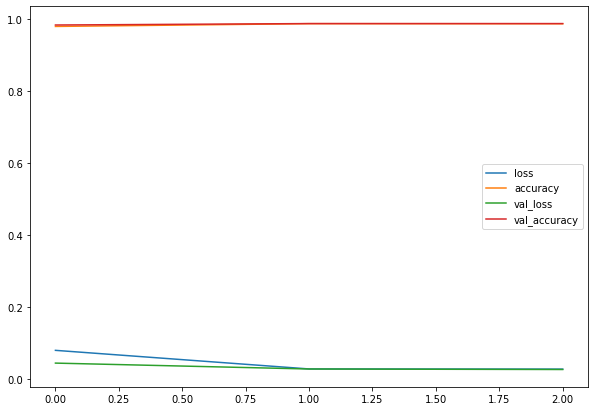

In [98]:
pd.DataFrame(model_1_history.history).plot(figsize=(10,7));

In [100]:
calculate_results(y_true=y_test_label_encoded,y_pred=model_preds)

{'accuracy': 98.78768256709117,
 'precision': 0.9886901549207875,
 'recall': 0.9878768256709116,
 'f1': 0.9879009444666509}